In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
    Input,
    Add,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import kagglehub
from datetime import datetime
from keras.preprocessing import image

In [ ]:
dataset_path = os.path.join(os.getcwd(), "CK+48")
sub_folders = os.listdir(dataset_path)
labels = []
images = []

for sub_folder in sub_folders:
    sub_folder_index = sub_folders.index(sub_folder)
    label = sub_folder_index
    path = os.path.join(dataset_path, sub_folder)
    sub_folder_images = os.listdir(path)
    for image in sub_folder_images:
        image_path = os.path.join(path, image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (48, 48))
        images.append(image)
        labels.append(label)

In [8]:
images_x = np.array(images)
labels_y = np.array(labels)
images_x = images_x / 255
print(images_x[0])
print(images_x[0].shape)
num_classes = len(sub_folders)
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes)
print(labels_y_encoded)
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.20, random_state=10)

[[0.09411765 0.03921569 0.05098039 ... 0.1372549  0.63921569 0.97254902]
 [0.06666667 0.03529412 0.06666667 ... 0.05490196 0.39607843 0.92156863]
 [0.03921569 0.04705882 0.06666667 ... 0.01568627 0.16862745 0.78823529]
 ...
 [0.87058824 0.87843137 0.87843137 ... 0.60392157 0.60784314 0.61960784]
 [0.89411765 0.89803922 0.89803922 ... 0.59607843 0.60784314 0.61960784]
 [0.91764706 0.92156863 0.91372549 ... 0.58823529 0.6        0.61176471]]
(48, 48)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [10]:
input = Input(shape=(48, 48, 1))
conv1 = Conv2D(
    32, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(
    64, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(
    128, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation("relu")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(
    256, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation("relu")(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)
dense1 = Dense(128, activation="relu")(flatten)
drop1 = Dropout(0.1)(dense1)
output = Dense(num_classes, activation="sigmoid")(drop1)

In [11]:
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=["accuracy"])
model.summary()
checkpoint_path = "models/model_checkpoint.keras"
checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
callback_list = [checkpointer]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,525 (2.61 MB)

 Trainable params: 683,525 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
save = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    validation_data=(X_test, Y_test),
    epochs=50,
    callbacks=callback_list,
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2976 - loss: 1.8465
Epoch 1: loss improved from inf to 1.78232, saving model to models/model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2973 - loss: 1.8433 - val_accuracy: 0.5133 - val_loss: 1.7290
Epoch 2/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3559 - loss: 1.6617
Epoch 2: loss improved from 1.78232 to 1.64843, saving model to models/model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3552 - loss: 1.6604 - val_accuracy: 0.2867 - val_loss: 1.6606
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4320 - loss: 1.5895
Epoch 3: loss improved from 1.64843 to 1.57534, saving model to models/model_checkpoint.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4329 - loss: 1.5888 - val_accuracy: 0.3267 - val_loss: 1.5790
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5394 - loss: 1.3943
Epoch 4: loss improved from 1.5753

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

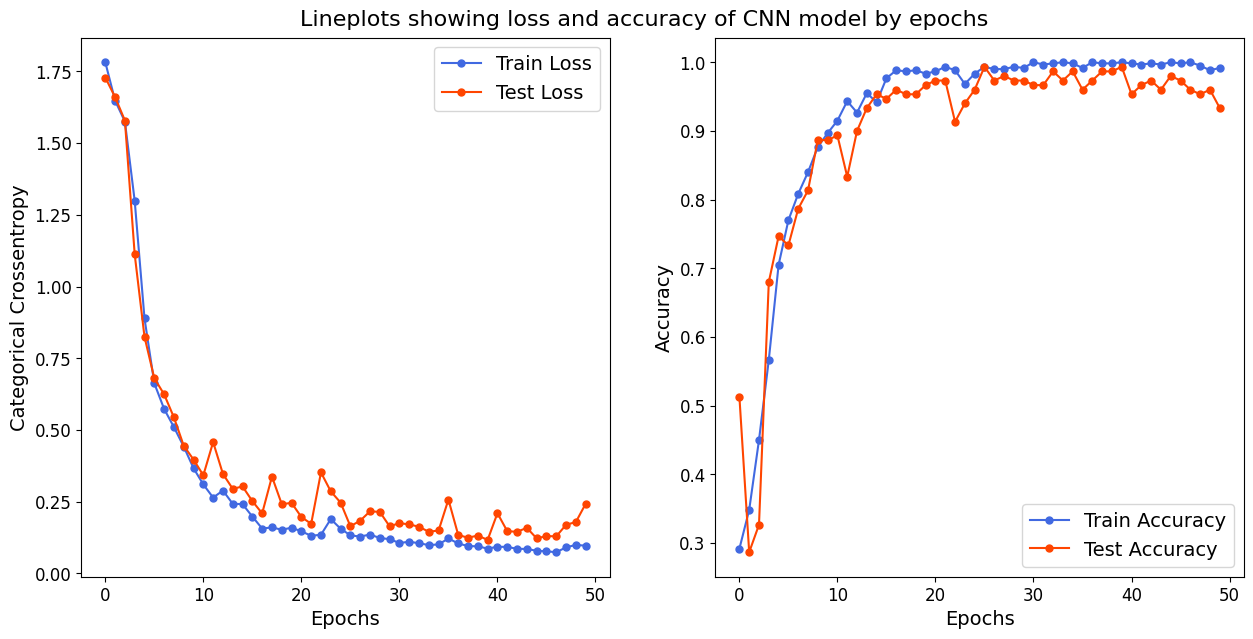

In [13]:
train_loss = save.history["loss"]
test_loss = save.history["val_loss"]
train_accuracy = save.history["accuracy"]
test_accuracy = save.history["val_accuracy"]

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label="Train Loss", color="royalblue", marker="o", markersize=5)
ax[0].plot(test_loss, label="Test Loss", color="orangered", marker="o", markersize=5)
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Categorical Crossentropy", fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="both", labelsize=12)
ax[1].plot(
    train_accuracy, label="Train Accuracy", color="royalblue", marker="o", markersize=5
)
ax[1].plot(
    test_accuracy, label="Test Accuracy", color="orangered", marker="o", markersize=5
)
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Accuracy", fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="both", labelsize=12)
fig.suptitle(
    x=0.5,
    y=0.92,
    t="Lineplots showing loss and accuracy of CNN model by epochs",
    fontsize=16,
)